# Importing Libraries

In [10]:
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Loading and Cleaning

In [11]:
def clean_amazon_data(filepath):
    # Load raw dataset
    df = pd.read_csv(filepath)
    
    # Drop unnecessary columns
    columns_to_drop = ["product_id", "product_name", "about_product", "user_id", "user_name", 
                       "review_id", "review_title", "review_content", "img_link", "product_link"]
    df.drop(columns=columns_to_drop, errors="ignore", inplace=True)
    
    # Extract the main category (first category listed)
    df["category"] = df["category"].astype(str).apply(lambda x: x.split('|')[0] if '|' in x else x)
    
    # numeric columns to correct format
    numeric_columns = ["discounted_price", "actual_price", "discount_percentage", "rating", "rating_count"]
    
    for col in numeric_columns:
        df[col] = df[col].astype(str).str.replace(r"[₹,%]", "", regex=True)
        df[col] = df[col].str.replace(",", "")
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filling missing values with column median
    for col in numeric_columns:
        df[col].fillna(df[col].median(), inplace=True)
    
    cleaned_filepath = "cleaned_amazon.csv"
    df.to_csv(cleaned_filepath, index=False)
    
    print(f"Data cleaned and saved as {cleaned_filepath}")

    return df

cleaned_data = clean_amazon_data("amazon.csv")

print("\nCleaned Data Preview:")
print(cleaned_data.head())


Data cleaned and saved as cleaned_amazon.csv

Cleaned Data Preview:
                category  discounted_price  actual_price  discount_percentage  \
0  Computers&Accessories             399.0        1099.0                   64   
1  Computers&Accessories             199.0         349.0                   43   
2  Computers&Accessories             199.0        1899.0                   90   
3  Computers&Accessories             329.0         699.0                   53   
4  Computers&Accessories             154.0         399.0                   61   

   rating  rating_count  
0     4.2       24269.0  
1     4.0       43994.0  
2     3.9        7928.0  
3     4.2       94363.0  
4     4.2       16905.0  


C:\Users\zaina\AppData\Local\Temp\ipykernel_25824\3455804484.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
C:\Users\zaina\AppData\Local\Temp\ipykernel_25824\3455804484.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

# Feature Engineering

In [ ]:
df = pd.read_csv("cleaned_amazon.csv")

# Defining Demand Level (High vs. Low)
median_reviews = df["rating_count"].median()
df["demand_level"] = np.where(df["rating_count"] >= median_reviews, 1, 0)

# Encoding Categorical Variables
encoder = LabelEncoder()
df["category_encoded"] = encoder.fit_transform(df["category"])

df["price_difference"] = df["actual_price"] - df["discounted_price"]

In [15]:
# Selecting Features & Target
features = ["discount_percentage", "rating", "rating_count", "category_encoded", "price_difference"]
target = "demand_level"

X = df[features]
y = df[target]

# Normalizing the Features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Model Development & Training

In [13]:
# Building Neural Network Model
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compiling Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the Model
history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test), verbose=1)

# Predict on Test Data
y_pred = (model.predict(X_test) > 0.5).astype("int32")

print("\nNeural Network Classification Report:\n", classification_report(y_test, y_pred))

# Saving Model & Scaler
model.save("demand_prediction_nn.keras")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(encoder, "category_encoder.pkl")

print("Neural Network Model saved successfully!")

# Example Prediction
example_product = np.array([50, 4.2, 1200, 3, 700])  # Updated features
example_scaled = scaler.transform(example_product.reshape(1, -1))
predicted_demand = model.predict(example_scaled)[0][0]

# Converting prediction back to category
predicted_demand_label = "High" if predicted_demand >= 0.5 else "Low"
print(f"Predicted Demand Level for Example Product: {predicted_demand_label}")

c:\Users\zaina\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6296 - loss: 0.6508 - val_accuracy: 0.7611 - val_loss: 0.5023
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7893 - loss: 0.4624 - val_accuracy: 0.8908 - val_loss: 0.3407
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8484 - loss: 0.3601 - val_accuracy: 0.9078 - val_loss: 0.2416
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8823 - loss: 0.2953 - val_accuracy: 0.9044 - val_loss: 0.2074
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9225 - loss: 0.2109 - val_accuracy: 0.9454 - val_loss: 0.1385
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8965 - loss: 0.2230 - val_accuracy: 0.9659 - val_loss: 0.1100
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9336 - loss: 0.1780 - val_accuracy: 0.9522 - val_loss: 0.1045
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9436 - loss: 0.1525 - val_accuracy: 0.9761 - val_loss:

c:\Users\zaina\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Model Evaluation

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0448 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.0361 
Neural Network Model Metrics:
Training Accuracy: 0.9863
Testing Accuracy: 0.9829
Precision: 0.9931
Recall: 0.9728
F1-Score: 0.9828
ROC-AUC Score: 0.9989


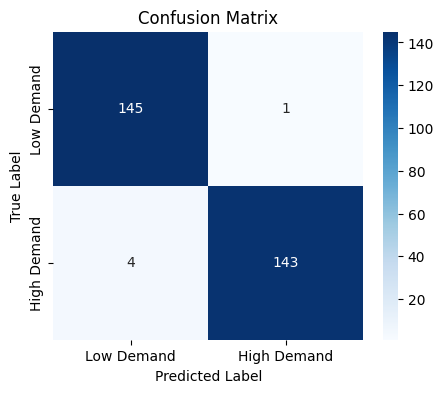

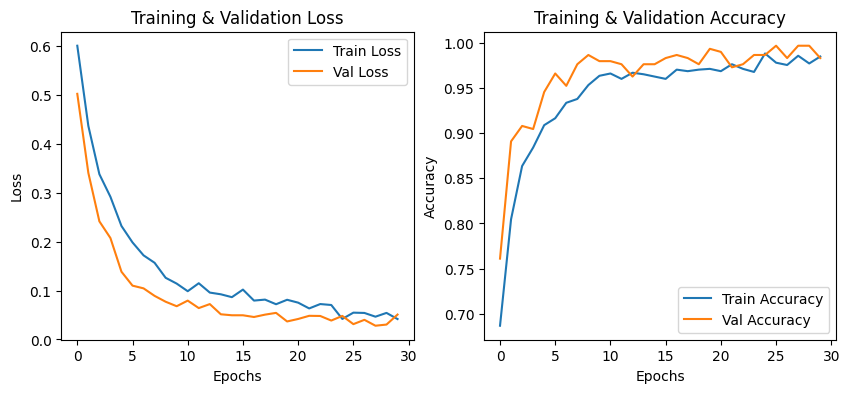

In [14]:
# Converting predictions to binary (0 or 1)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)


print(f"Neural Network Model Metrics:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Confusion Matrix
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["Low Demand", "High Demand"], yticklabels=["Low Demand", "High Demand"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(10, 4))

# Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()
